# Particles Filter
## Zein Alabedeen Barhoum

# Task:

**Robot description:**

A mobile robot is located in a square area 1000 meters long. Radio beacons are installed in the corners of the area. The robot can measure the distance to beacons. The measurement error is described by a normal distribution with zero mean and standard deviation $\sigma = 15$. It is known that the initial position of the robot is in the range of coordinates (0-100, 0-100). The initial orientation of the robot is $0 \pm 2$ degrees.

The robot functions as follows:

- Accepts from the operator the required angle of rotation and range of movement;
- Rotates to a given angle;
- Moves for a given distance;
- Measures the distance to beacons;
- Calculates position.

The robot rotates through a given angle with a normally distributed error with zero mean and standard deviation $\sigma_{\theta} = 2$. The robot moves to a given distance with a normally distributed error with zero mean and standard deviation $\sigma_{l} = 15$. It is required to build a particle filter to improve the localization accuracy of the robot.

**Tasks:**

- Set the initial position of the robot and standard deviations;
- Set at least 5 commands to move the robot;
- Build the trajectory of the robot's movement, taking into account errors;
- Build a particle filter for the robot;
- Build a trajectory of the robot's movement, the position of the particles and an estimate of the position of the robot after the execution of each of the commands;
- Repeat the previous steps for three different initial positions, standard deviations, number of particles and motion paths.

# Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sigma_l = 15
sigma_ang = 2

sigma_meas = 15

# sigma_l = 0
# sigma_ang = 0

# sigma_meas = 0

xinit = 500
yinit = 300

robotX = xinit+np.random.normal(0, sigma_l)
robotY = yinit+np.random.normal(0, sigma_l)

robotPos = np.array([robotX,robotY])
robotA = 1

def movement(pos, u):
    x = list(pos)
    ang = u[0]+np.random.normal(0, sigma_ang)
    l = u[1]+np.random.normal(0, sigma_l)
    # ang = u[0]
    # l = u[1]
    
    x_new =x.copy()
    x_new[0]+= l*np.cos(np.radians(ang))
    x_new[1]+= l*np.sin(np.radians(ang))
    return np.array(x_new)

#example command, rotate to -90 degrees and move 100 meters
robotPos, movement(robotPos, (np.pi*-1/2, 100))

(array([504.19403295, 302.38165429]), array([633.07861347, 297.31707093]))

In [2]:
def measurement(pos):
    x_meas = pos[0] + np.random.normal(0, sigma_meas)
    y_meas = pos[1] + np.random.normal(0, sigma_meas)
    return np.array([x_meas,y_meas])
robotPos,measurement(robotPos)

(array([504.19403295, 302.38165429]), array([526.45006088, 294.86240062]))

In [3]:
u = [(60, 100),
     (-90, 300),
     (30, 130),
     (-45, 115),
     (90, 200),]
     

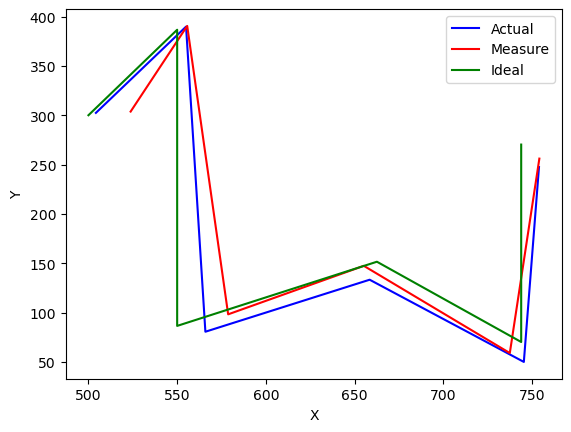

In [4]:
X = [robotPos[0]]
Y = [robotPos[1]]
X_meas = [measurement(robotPos)[0]]
Y_meas = [measurement(robotPos)[1]]

T = [0]

X_ideal = [xinit]
Y_ideal = [yinit]

for k in range(1, len(u)+1):
    T.append(k)
    
    robotPos = movement(robotPos, u[k-1])
    X.append(robotPos[0])
    Y.append(robotPos[1])
    robotMeas = measurement(robotPos)
    X_meas.append(robotMeas[0])
    Y_meas.append(robotMeas[1])
    
    X_ideal.append(X_ideal[k-1] + u[k-1][1]*np.cos(np.radians(u[k-1][0])))
    Y_ideal.append(Y_ideal[k-1] + u[k-1][1]*np.sin(np.radians(u[k-1][0])))

plt.plot(X, Y, c='b')
plt.plot(X_meas, Y_meas, c='r')
plt.plot(X_ideal, Y_ideal, c='g')

plt.legend(['Actual','Measure','Ideal'])

plt.xlabel('X')
plt.ylabel('Y')

plt.show()  

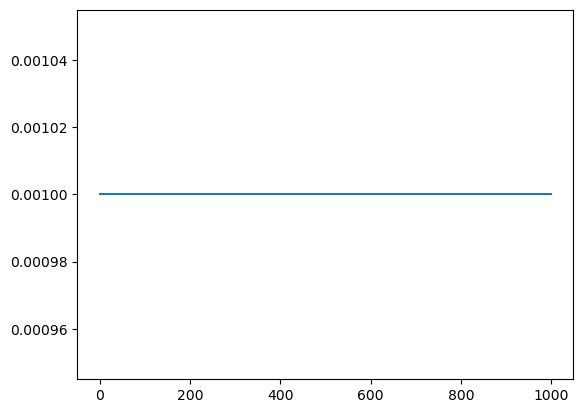

In [5]:
N_particles = 1000
particles_X = np.zeros(N_particles)
particles_Y = np.zeros(N_particles)

for i in range(N_particles):
    particles_X[i] = xinit + np.random.normal(0,sigma_l)
    particles_Y[i] = yinit + np.random.normal(0,sigma_l)
weights = np.ones(N_particles) / N_particles

plt.plot(range(N_particles), weights)
plt.show()

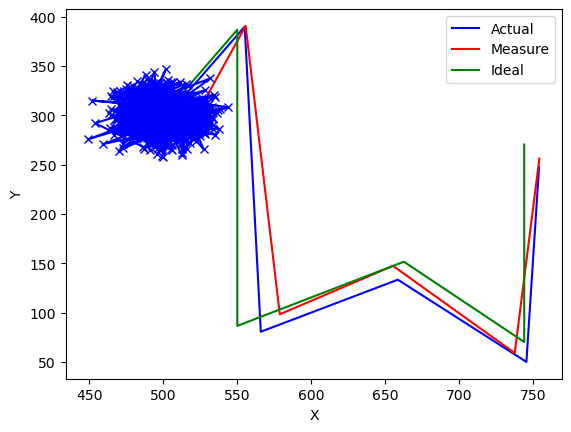

In [6]:
plt.plot(X, Y, c='b')
plt.plot(X_meas, Y_meas, c='r')
plt.plot(X_ideal, Y_ideal, c='g')
plt.plot(particles_X, particles_Y, c='b', marker='x')

plt.legend(['Actual','Measure','Ideal'])

plt.xlabel('X')
plt.ylabel('Y')

plt.show()  

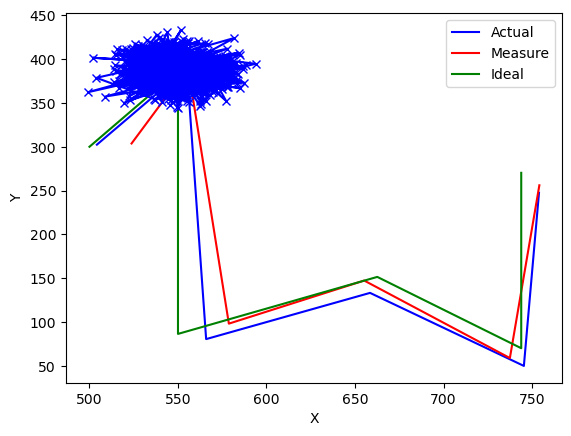

In [7]:
def move_particles(particlesX, particlesY, u):
    new_particlesX = []
    new_particlesY = []
    for particleX in particlesX:
        new_particlesX.append(particleX + u[1]*np.cos(np.radians(u[0])))
    for particleY in particlesY:
        new_particlesY.append(particleY + u[1]*np.sin(np.radians(u[0])))
    return new_particlesX,new_particlesY

new_particlesX, new_particlesY= move_particles(particles_X,particles_Y, u[0])

plt.plot(X, Y, c='b')
plt.plot(X_meas, Y_meas, c='r')
plt.plot(X_ideal, Y_ideal, c='g')
plt.plot(new_particlesX, new_particlesY, c='b', marker='x')

plt.legend(['Actual','Measure','Ideal'])

plt.xlabel('X')
plt.ylabel('Y')

plt.show()  

<BarContainer object of 1000 artists>

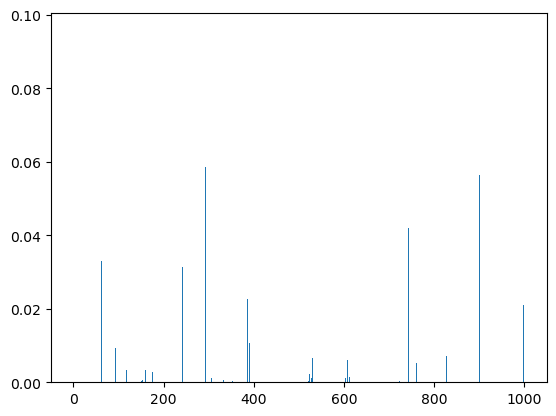

In [8]:
def prob(dist, meas_dist):
    return 1/np.sqrt(2 * np.pi * sigma_meas) * np.exp( -(dist - meas_dist)**2 / sigma_meas )

def weight_calc(particlesX,particlesY, weights, robot_measurementX, robot_measurementY):
    for i in range(N_particles):
        weights[i] = prob(particlesX[i], robot_measurementX)*prob(particlesY[i], robot_measurementY)
    weights = weights / np.sum(weights)
    return weights

new_weights = weight_calc(particles_X,particles_Y, weights, X_meas[0], Y_meas[0])

plt.bar(range(N_particles), new_weights)

In [9]:
def resample(particlesX,particlesY, weights):
    newParticlesX = []
    newParticlesY = []
    newWeights = []
    N = len(particlesX)
    index = np.random.randint(0, N)
    betta = 0
    for i in range(N):
        betta = betta + np.random.uniform(0, 2*max(weights))
        while betta > weights[index]:
            betta = betta - weights[index]
            index = (index + 1)%N # index changes in a loop from 0 to N
        newParticlesX.append(particlesX[index])
        newParticlesY.append(particlesY[index])
        newWeights.append(weights[index])
    newWeights = newWeights / np.sum(newWeights)
    
    return np.array(newParticlesX), np.array(newParticlesY), newWeights

In [10]:
def estimation(particlesX,particlesY, weights):
    estimateX = 0
    estimateY = 0
    for i in range(len(particlesX)):
        estimateX = estimateX + particlesX[i] * weights[i]
        estimateY = estimateY + particlesY[i] * weights[i]
    return estimateX,estimateY

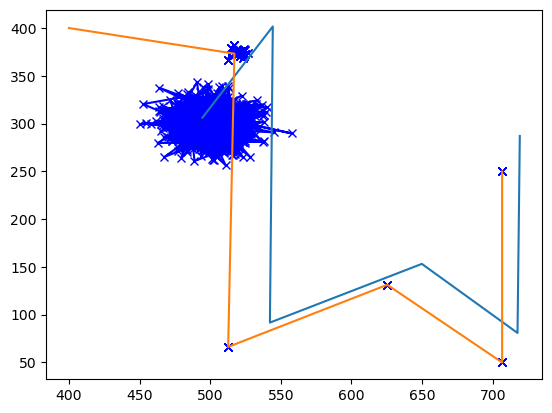

In [11]:
u = [(60, 100),
     (-90, 300),
     (30, 130),
     (-45, 115),
     (90, 200),]

xinit = 500
yinit = 300

sigma_l = 15
sigma_ang = 2

sigma_meas = 15

robotX = xinit+np.random.normal(0, sigma_l)
robotY = yinit+np.random.normal(0, sigma_l)

robotPos = np.array([robotX,robotY])

N_particles = 1000
particles_X = np.zeros(N_particles)
particles_Y = np.zeros(N_particles)

for i in range(N_particles):
    particles_X[i] = xinit + np.random.normal(0,sigma_l)
    particles_Y[i] = yinit + np.random.normal(0,sigma_l)
weights = np.ones(N_particles) / N_particles



X = [robotPos[0]]
Y = [robotPos[1]]
X_meas = [measurement(robotPos)[0]]
Y_meas = [measurement(robotPos)[1]]

T = [0]

X_est = [400]
Y_est = [400]

for step in range(1,len(u)+1):
    plt.plot(particles_X, particles_Y, c='b', marker='x')
    T.append(step)
    
    robotPos = movement(robotPos, u[step-1])
    X.append(robotPos[0])
    Y.append(robotPos[1])
    robotMeas = measurement(robotPos)
    X_meas.append(robotMeas[0])
    Y_meas.append(robotMeas[1])
    
    particles_X, particles_Y= move_particles(particles_X,particles_Y, u[step-1])
    weights = weight_calc(particles_X,particles_Y, weights, robotMeas[0], robotMeas[1])
    
    particles_X,particles_Y, weights = resample(particles_X,particles_Y, weights)
    
    estX, estY = estimation(particles_X,particles_Y, weights)
    X_est.append(estX)
    Y_est.append(estY)
plt.plot(particles_X, particles_Y, c='b', marker='x')
plt.plot(X, Y)
plt.plot(X_est, Y_est)
plt.show()

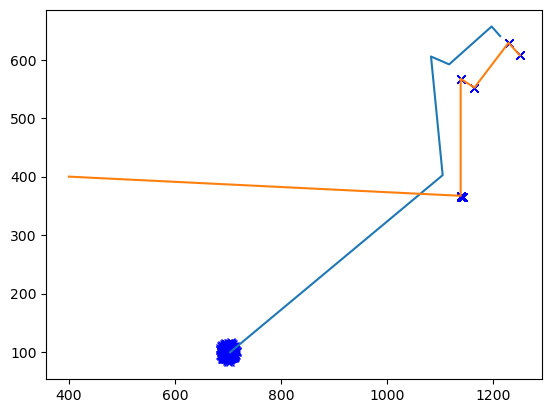

In [12]:
u = [(30, 500),
     (90, 200),
     (-30, 30),
     (50, 100),
     (-45, 30),]

xinit = 700
yinit = 100

sigma_l = 5
sigma_ang = 10

sigma_meas = 30

robotX = xinit+np.random.normal(0, sigma_l)
robotY = yinit+np.random.normal(0, sigma_l)

robotPos = np.array([robotX,robotY])

N_particles = 2000
particles_X = np.zeros(N_particles)
particles_Y = np.zeros(N_particles)

for i in range(N_particles):
    particles_X[i] = xinit + np.random.normal(0,sigma_l)
    particles_Y[i] = yinit + np.random.normal(0,sigma_l)
weights = np.ones(N_particles) / N_particles



X = [robotPos[0]]
Y = [robotPos[1]]
X_meas = [measurement(robotPos)[0]]
Y_meas = [measurement(robotPos)[1]]

T = [0]

X_est = [400]
Y_est = [400]

for step in range(1,len(u)+1):
    plt.plot(particles_X, particles_Y, c='b', marker='x')
    T.append(step)
    
    robotPos = movement(robotPos, u[step-1])
    X.append(robotPos[0])
    Y.append(robotPos[1])
    robotMeas = measurement(robotPos)
    X_meas.append(robotMeas[0])
    Y_meas.append(robotMeas[1])
    
    particles_X, particles_Y= move_particles(particles_X,particles_Y, u[step-1])
    weights = weight_calc(particles_X,particles_Y, weights, robotMeas[0], robotMeas[1])
    
    particles_X,particles_Y, weights = resample(particles_X,particles_Y, weights)
    
    estX, estY = estimation(particles_X,particles_Y, weights)
    X_est.append(estX)
    Y_est.append(estY)
plt.plot(particles_X, particles_Y, c='b', marker='x')
plt.plot(X, Y)
plt.plot(X_est, Y_est)
plt.show()

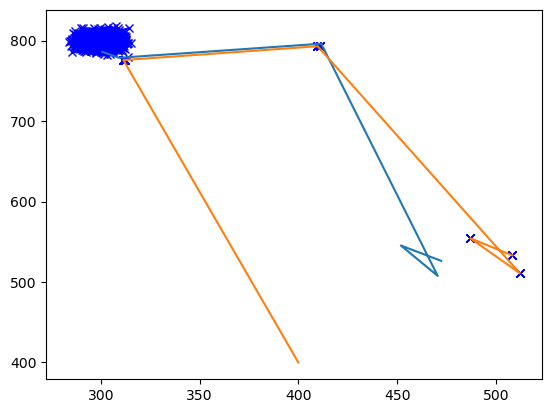

In [13]:
u = [(-40, 10),
     (10, 100),
     (-70, 300),
     (120, 50),
     (-45, 30),]

xinit = 300
yinit = 800

sigma_l = 5
sigma_ang = 3

sigma_meas = 10

robotX = xinit+np.random.normal(0, sigma_l)
robotY = yinit+np.random.normal(0, sigma_l)

robotPos = np.array([robotX,robotY])

N_particles = 3000
particles_X = np.zeros(N_particles)
particles_Y = np.zeros(N_particles)

for i in range(N_particles):
    particles_X[i] = xinit + np.random.normal(0,sigma_l)
    particles_Y[i] = yinit + np.random.normal(0,sigma_l)
weights = np.ones(N_particles) / N_particles



X = [robotPos[0]]
Y = [robotPos[1]]
X_meas = [measurement(robotPos)[0]]
Y_meas = [measurement(robotPos)[1]]

T = [0]

X_est = [400]
Y_est = [400]

for step in range(1,len(u)+1):
    plt.plot(particles_X, particles_Y, c='b', marker='x')
    T.append(step)
    
    robotPos = movement(robotPos, u[step-1])
    X.append(robotPos[0])
    Y.append(robotPos[1])
    robotMeas = measurement(robotPos)
    X_meas.append(robotMeas[0])
    Y_meas.append(robotMeas[1])
    
    particles_X, particles_Y= move_particles(particles_X,particles_Y, u[step-1])
    weights = weight_calc(particles_X,particles_Y, weights, robotMeas[0], robotMeas[1])
    
    particles_X,particles_Y, weights = resample(particles_X,particles_Y, weights)
    
    estX, estY = estimation(particles_X,particles_Y, weights)
    X_est.append(estX)
    Y_est.append(estY)
plt.plot(particles_X, particles_Y, c='b', marker='x')
plt.plot(X, Y)
plt.plot(X_est, Y_est)
plt.show()